# Final Project

Paul Parks, Alden Caterio, Mayank Bhatt

In [870]:
# imports
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import mean_absolute_error

## Datasets

In [871]:
wine_white = pd.read_csv('../Dataset/wine+quality/winequality-white.csv', sep=';')
wine_white.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [872]:
wine_red = pd.read_csv('../Dataset/wine+quality/winequality-red.csv', sep=';')
wine_red.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [873]:
columns = [
    'fixed acidity',
    'volatile acidity',
    'citric acid',
    'residual sugar',
    'chlorides',
    'free sulfur dioxide',
    'total sulfur dioxide',
    'density',
    'pH',
    'sulphates',
    'alcohol',
    'quality'
]

## Boxplot all data to view outliers

In [874]:
def do_boxplot(data):
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15,10))
    axes = axes.ravel()
    for i, column in enumerate(columns):
        axes[i].boxplot(data[column])
        axes[i].set_title(f'Boxplot of {column}')
    plt.tight_layout()
    plt.show()

BoxPlots Red Wine


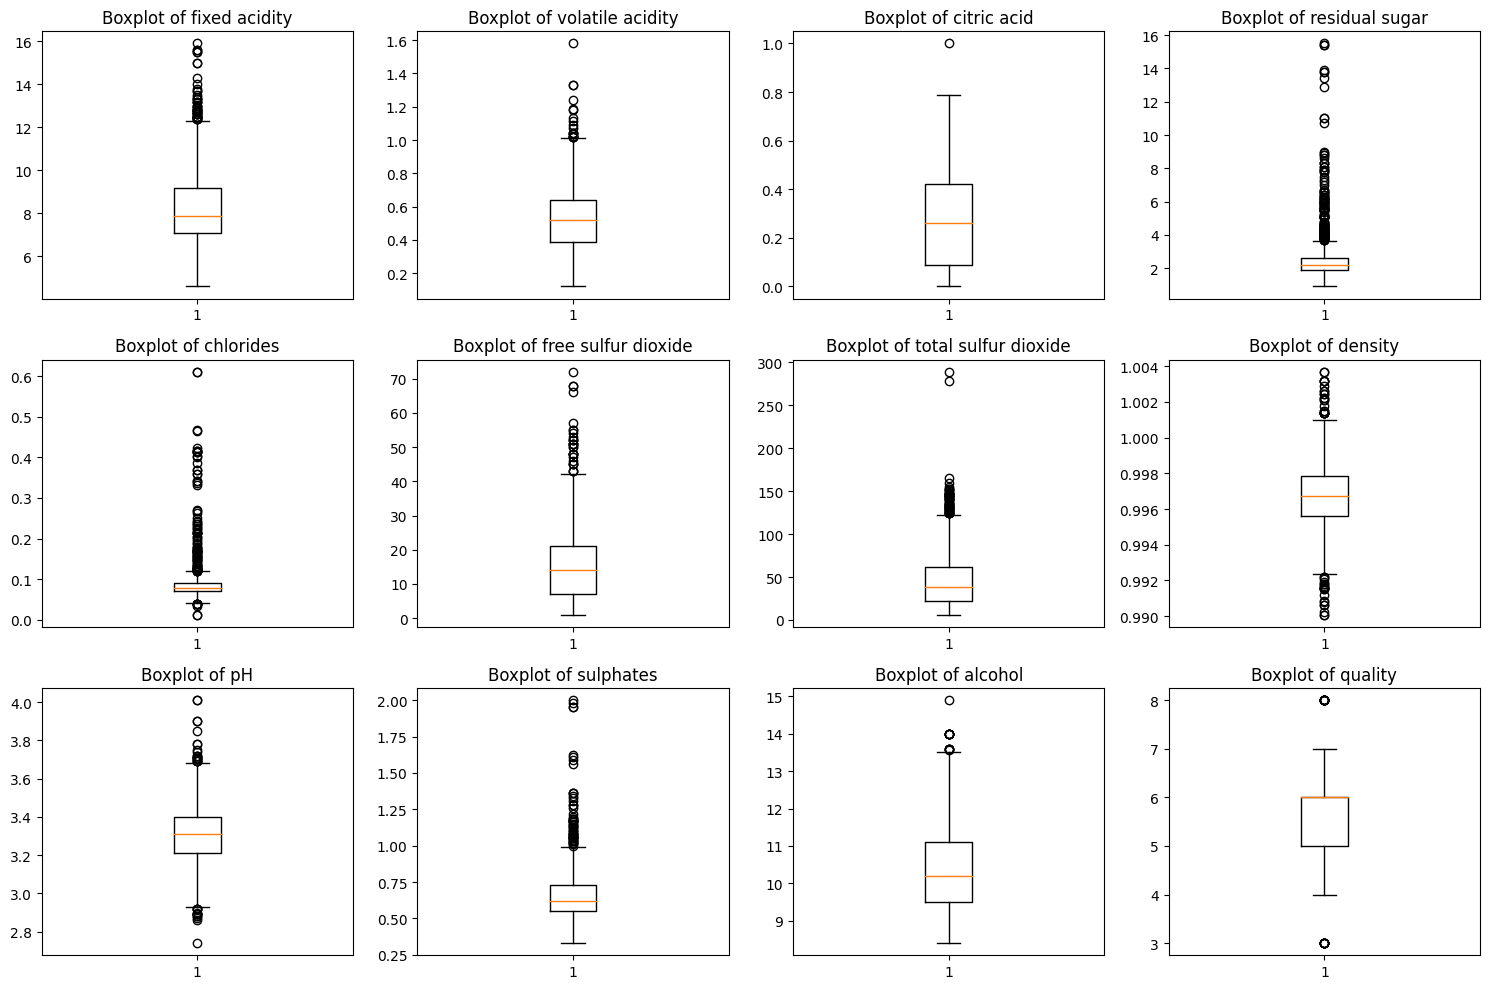

In [875]:
print('BoxPlots Red Wine')
do_boxplot(wine_red)

BoxPlots White Wine


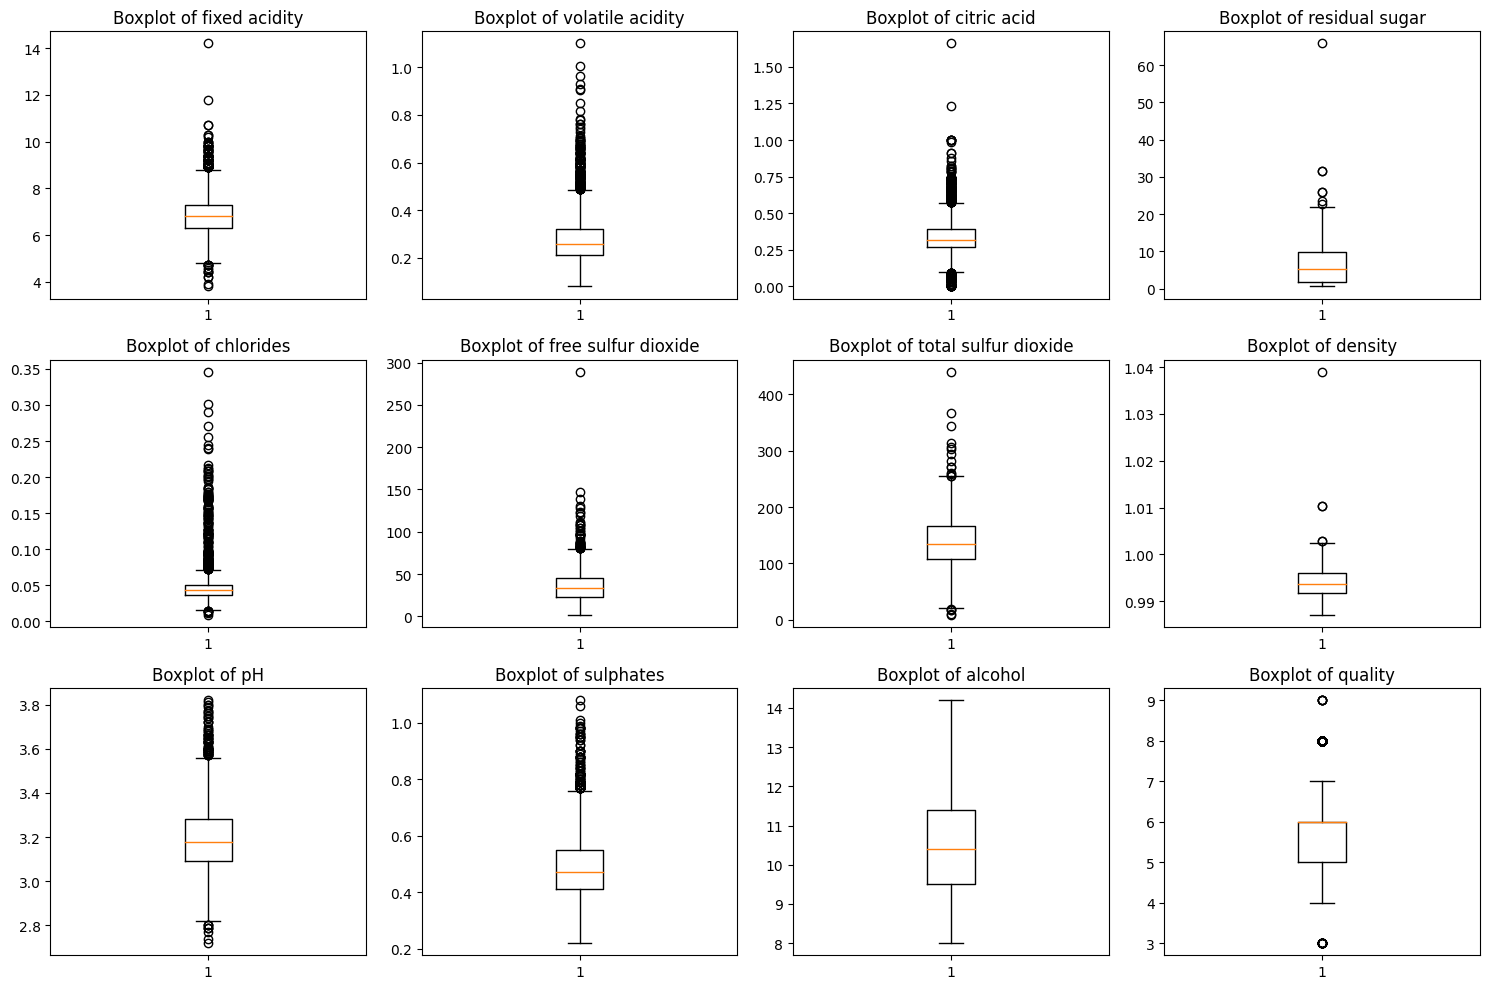

In [876]:
print('BoxPlots White Wine')
do_boxplot(wine_white)

## Probability of Scores

In [877]:
def get_probability(df):
    df.sort_values(by=['quality'], inplace=True)
    df_mean = np.mean(df["quality"])
    df_std = np.std(df["quality"])
    pdf = stats.norm.pdf(df["quality"], df_mean, df_std)

    plt.xlabel('Quality')
    plt.ylabel('Probability')
    plt.title('PDF of Quality')
    plt.plot(df["quality"], pdf)

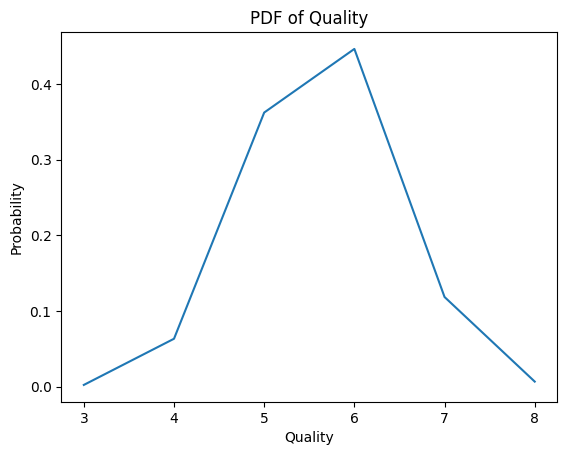

In [878]:
get_probability(wine_red)

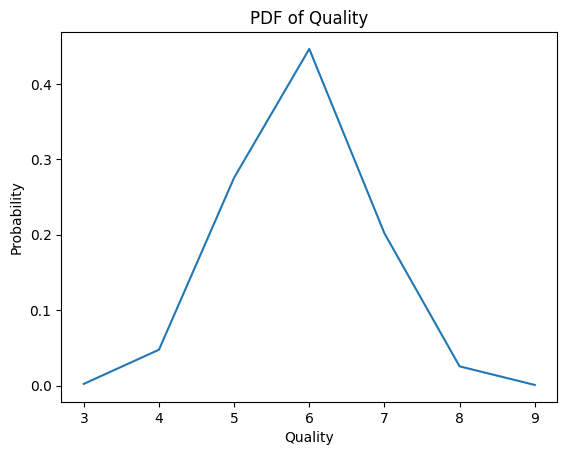

In [879]:
get_probability(wine_white)

## Remove all outliers

In [880]:
def remove_all_outliers(data_source):
    data = data_source.copy()
    for column in columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        data = data[(data[column] >= Q1 - 1.5*IQR) & (data[column] <= Q3 + 1.5*IQR)]
    return data

In [881]:
wine_red_cleaned = remove_all_outliers(wine_red)
wine_white_cleaned = remove_all_outliers(wine_red)

## Generalized Linear Model Regression

In [882]:
def create_glm_fitted_model(df):
    X = df.drop('quality', axis=1)
    y = df['quality']

    X = sm.add_constant(X)

    # Create the model
    model = sm.GLM(y, X)
    return model.fit()

In [883]:
wine_red_results = create_glm_fitted_model(wine_red)
print(wine_red_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                quality   No. Observations:                 1599
Model:                            GLM   Df Residuals:                     1587
Model Family:                Gaussian   Df Model:                           11
Link Function:               Identity   Scale:                         0.41992
Method:                          IRLS   Log-Likelihood:                -1569.1
Date:                Sat, 17 Jun 2023   Deviance:                       666.41
Time:                        11:24:35   Pearson chi2:                     666.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4286
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   21.9652 

```
The variables 'volatile acidity', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'pH', 'sulphates', and 'alcohol' are statistically significant predictors of wine quality because their p-values are less than 0.05.
```

In [884]:
wine_white_results = create_glm_fitted_model(wine_white)
print(wine_white_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                quality   No. Observations:                 4898
Model:                            GLM   Df Residuals:                     4886
Model Family:                Gaussian   Df Model:                           11
Link Function:               Identity   Scale:                         0.56454
Method:                          IRLS   Log-Likelihood:                -5543.7
Date:                Sat, 17 Jun 2023   Deviance:                       2758.3
Time:                        11:24:35   Pearson chi2:                 2.76e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.3240
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  150.1928 

```
The variables 'volatile acidity', 'residual sugar', 'free sulfur dioxide', 'density', 'pH', 'sulphates', and 'alcohol' are statistically significant predictors of wine quality because their p-values are less than 0.05.
```

In [885]:
wine_red_cleaned_results = create_glm_fitted_model(wine_red_cleaned)
print(wine_red_cleaned_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                quality   No. Observations:                 1124
Model:                            GLM   Df Residuals:                     1112
Model Family:                Gaussian   Df Model:                           11
Link Function:               Identity   Scale:                         0.33074
Method:                          IRLS   Log-Likelihood:                -967.05
Date:                Sat, 17 Jun 2023   Deviance:                       367.79
Time:                        11:24:35   Pearson chi2:                     368.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4471
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   13.3441 

In [886]:
wine_white_cleaned_results = create_glm_fitted_model(wine_white_cleaned)
print(wine_white_cleaned_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                quality   No. Observations:                 1124
Model:                            GLM   Df Residuals:                     1112
Model Family:                Gaussian   Df Model:                           11
Link Function:               Identity   Scale:                         0.33074
Method:                          IRLS   Log-Likelihood:                -967.05
Date:                Sat, 17 Jun 2023   Deviance:                       367.79
Time:                        11:24:35   Pearson chi2:                     368.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4471
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   13.3441 

## Predictions - Red Wine

In [887]:
def predict_wine_using_df(df_source, results):
    df = df_source.copy()
    
    get_mse_predictions(df, results)

    X = df.drop('quality', axis=1)
    X = sm.add_constant(X)
    y = df['quality']
    index = random.randint(0, len(df))
    row = X.iloc[index]
    predicted_quality = results.predict(row)
    print('Predicted wine quality:', predicted_quality[0])
    print('Predicted wine quality rounded:', round(predicted_quality[0]))
    print('Actual wine quality:', y.iloc[index])

In [888]:
def get_mse_predictions(df, results):
    X = df.drop('quality', axis=1)
    X = sm.add_constant(X)
    y = df['quality']
    predictions = results.predict(X)
    mae = mean_absolute_error(y, predictions)
    print(f'Mean Absolute Error: {mae}')


In [889]:
def predict_simulated_best_wine(data_source, results):
    # new_wine = {
    #     'const': [1],
    #     'fixed acidity': [8.5],
    #     'volatile acidity': [0.8],
    #     'citric acid': [0.56],
    #     'residual sugar': [1.8],
    #     'chlorides': [0.077],
    #     'free sulfur dioxide': [10.0],
    #     'total sulfur dioxide': [37.0],
    #     'density': [0.9968],
    #     'pH': [3.2],
    #     'sulphates': [0.68],
    #     'alcohol': [9.8]
    # }
    data = data_source.copy()
    # get the best scoring wine in the real dataset
    X = sm.add_constant(data)
    max_quality_index = X['quality'].idxmax()
    max_quality_row = X.loc[max_quality_index]
    actual_score = max_quality_row['quality']
    print(f'Actual quality: {actual_score}')
    max_quality_row = max_quality_row.drop('quality')

    # Statistically significant values for both red and white wines
    # tldr how to get a 11/10 wine
    max_quality_row['alcohol'] = 15
    max_quality_row['sulphates'] = 2
    max_quality_row['volatile acidity'] = 0.1
    max_quality_row['total sulfur dioxide'] = 30
    max_quality_row['pH'] = 2

    print(max_quality_row)
    predicted_quality = results.predict(max_quality_row)
    print(f'\nPredicted wine quality: {round(predicted_quality[0])}\n')


In [890]:
print('\nRed Wine prediction: \n')
predict_wine_using_df(wine_red, wine_red_results)

print('\nWhite Wine prediction: \n')
predict_wine_using_df(wine_white, wine_white_results)

print('\nRed Wine Cleaned prediction: \n')
predict_wine_using_df(wine_red_cleaned, wine_red_cleaned_results)

print('\nWhite Wine Cleaned prediction: \n')
predict_wine_using_df(wine_white_cleaned, wine_white_cleaned_results)


Red Wine prediction: 

Mean Absolute Error: 0.500489963564491
Predicted wine quality: 6.103833814717129
Predicted wine quality rounded: 6
Actual wine quality: 7

White Wine prediction: 

Mean Absolute Error: 0.5836349500279457
Predicted wine quality: 5.2819454153212035
Predicted wine quality rounded: 5
Actual wine quality: 5

Red Wine Cleaned prediction: 

Mean Absolute Error: 0.4593529800397901
Predicted wine quality: 5.613478506770926
Predicted wine quality rounded: 6
Actual wine quality: 6

White Wine Cleaned prediction: 

Mean Absolute Error: 0.4593529800397901
Predicted wine quality: 6.328978261687929
Predicted wine quality rounded: 6
Actual wine quality: 6


In [891]:
print('\nRed Wine prediction: \n')
predict_simulated_best_wine(wine_red, wine_red_cleaned_results)


Red Wine prediction: 

Actual quality: 8.0
const                    1.0000
fixed acidity            5.5000
volatile acidity         0.1000
citric acid              0.0300
residual sugar           1.8000
chlorides                0.0440
free sulfur dioxide     28.0000
total sulfur dioxide    30.0000
density                  0.9908
pH                       2.0000
sulphates                2.0000
alcohol                 15.0000
Name: 1269, dtype: float64

Predicted wine quality: 11



In [892]:
print('\nWhite Wine prediction: \n')
predict_simulated_best_wine(wine_white, wine_white_cleaned_results)


White Wine prediction: 

Actual quality: 9.0
const                    1.000
fixed acidity            9.100
volatile acidity         0.100
citric acid              0.450
residual sugar          10.600
chlorides                0.035
free sulfur dioxide     28.000
total sulfur dioxide    30.000
density                  0.997
pH                       2.000
sulphates                2.000
alcohol                 15.000
Name: 774, dtype: float64

Predicted wine quality: 11



In [893]:
def predict_simulated_best_wine_only_modify_pH_and_alcohol(data_source, results):
    predicted_scores_original = []
    predicted_scores_with_modifications = []
    score_diff = []

    data = data_source.copy()
    X = sm.add_constant(data)

    for row_iter in range(len(data)):
        row = X.loc[row_iter]
        row = row.drop('quality')
        predicted_quality = results.predict(row)
        row['alcohol'] = row['alcohol'] + 1.5
        row['pH'] = row['pH'] - 1.5
        predicted_quality_modified = results.predict(row)
        predicted_scores_original.append(predicted_quality[0])
        predicted_scores_with_modifications.append(predicted_quality_modified[0])
        score_diff = predicted_quality_modified[0] - predicted_quality[0]

    sns.kdeplot(predicted_scores_original, label='Predicted Score (Original)')
    sns.kdeplot(predicted_scores_with_modifications, label="Predicted Score (+1% abv -1%pH)")
    
    plt.legend()
    plt.show()
    print(f'Average Score difference (Score point out of 10): {np.mean(score_diff)}')

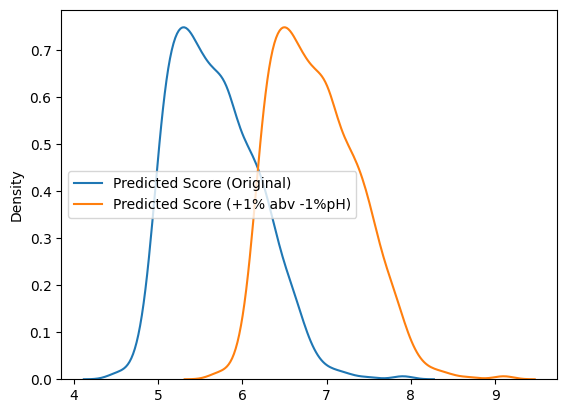

Average Score difference (Score point out of 10): 1.1965024634214307


In [894]:
# pH and Alcohol and both easily adjustable post fermentation. 
# What would happen to our wine scores if we increased alcohol and decreased pH?
predict_simulated_best_wine_only_modify_pH_and_alcohol(wine_red, wine_red_cleaned_results)

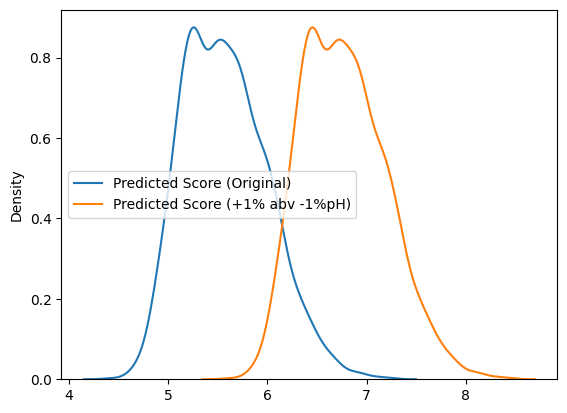

Average Score difference (Score point out of 10): 1.1965024634214307


In [895]:
predict_simulated_best_wine_only_modify_pH_and_alcohol(wine_white, wine_white_cleaned_results)

`
Increasing alcohol percentage by 1.5 and lowering pH by 1.5 gains an average of 1 whole score point. 
`